In [1]:
!pip install tqdm

     |████████████████████████████████| 76 kB 6.5 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pydot
!pip install graphviz

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [3]:
import json
from tqdm import tqdm
import collections
import random
import numpy as np

In [4]:
annotation_file='./annotations/captions_train2014.json'
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [5]:
annotations

{'info': {'description': 'COCO 2014 Dataset',
  'url': 'http://cocodataset.org',
  'version': '1.0',
  'year': 2014,
  'contributor': 'COCO Consortium',
  'date_created': '2017/09/01'},
 'images': [{'license': 5,
   'file_name': 'COCO_train2014_000000057870.jpg',
   'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000057870.jpg',
   'height': 480,
   'width': 640,
   'date_captured': '2013-11-14 16:28:13',
   'flickr_url': 'http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg',
   'id': 57870},
  {'license': 5,
   'file_name': 'COCO_train2014_000000384029.jpg',
   'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000384029.jpg',
   'height': 429,
   'width': 640,
   'date_captured': '2013-11-14 16:29:45',
   'flickr_url': 'http://farm3.staticflickr.com/2422/3577229611_3a3235458a_z.jpg',
   'id': 384029},
  {'license': 1,
   'file_name': 'COCO_train2014_000000222016.jpg',
   'coco_url': 'http://images.cocodataset.org/train2014/COCO_tr

In [6]:
# Group all captions together having the same image ID.
PATH='train2014/'
image_path_to_caption = collections.defaultdict(list)
for val in tqdm(annotations['annotations']):
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

100%|██████████| 414113/414113 [00:00<00:00, 516200.42it/s]


In [9]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:45000]
print(len(train_image_paths))

45000


In [19]:
# print(train_image_paths[:5])
new_paths=[path+'\n' for path in train_image_paths]
with open('train_image_paths.txt','w') as f:
    f.writelines(new_paths)

In [7]:
with open('train_image_paths.txt','r') as f:
    train_image_paths=f.readlines()
len(train_image_paths),train_image_paths[0][:-1]

(45000, 'train2014/COCO_train2014_000000128250.jpg')

In [8]:
train_image_paths=[path[:-1] for path in train_image_paths]
train_image_paths[0],len(train_image_paths)

('train2014/COCO_train2014_000000128250.jpg', 45000)

In [9]:
train_captions = []#list of all captions
img_name_vector = []#list of all paths

for image_path in tqdm(train_image_paths):
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

100%|██████████| 45000/45000 [00:00<00:00, 419457.43it/s]


In [1]:
# 1img->5cap
45000*5

225000

<start> A skateboarder performing a trick on a skateboard ramp. <end>


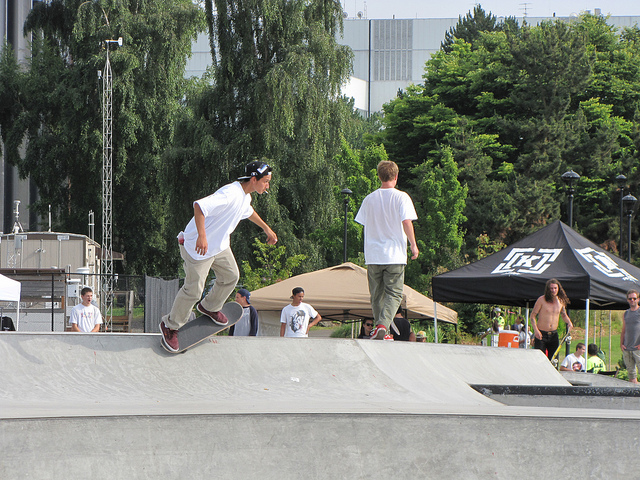

In [11]:
from PIL import Image
print(train_captions[10])
Image.open(img_name_vector[10])

# Preprocess the image using InceptionV3

In [10]:
import tensorflow as tf

In [11]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [12]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 2s 0us/step


In [13]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)


In [16]:
for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    #print(path_of_feature)
    np.save(path_of_feature, bf.numpy())

2813it [18:19,  2.56it/s]


In [150]:
1322*16#5174

21152

# Text Preprocessing and Tokenization

In [14]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [14]:
# Choose the top 5000 words from the vocabulary
top_k = 8000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

In [15]:
len(tokenizer.word_index),tokenizer.word_index

(18763,
 {'<unk>': 1,
  'a': 2,
  '<start>': 3,
  '<end>': 4,
  'on': 5,
  'of': 6,
  'the': 7,
  'in': 8,
  'with': 9,
  'and': 10,
  'is': 11,
  'man': 12,
  'to': 13,
  'sitting': 14,
  'an': 15,
  'two': 16,
  'standing': 17,
  'at': 18,
  'people': 19,
  'are': 20,
  'next': 21,
  'white': 22,
  'woman': 23,
  'street': 24,
  'table': 25,
  'holding': 26,
  'that': 27,
  'some': 28,
  'person': 29,
  'large': 30,
  'it': 31,
  'down': 32,
  'top': 33,
  'group': 34,
  'up': 35,
  'field': 36,
  'small': 37,
  'front': 38,
  'near': 39,
  'his': 40,
  'tennis': 41,
  'black': 42,
  'plate': 43,
  'dog': 44,
  'train': 45,
  'room': 46,
  'riding': 47,
  'by': 48,
  'red': 49,
  'young': 50,
  'cat': 51,
  'water': 52,
  'baseball': 53,
  'has': 54,
  'while': 55,
  'playing': 56,
  'bathroom': 57,
  'sign': 58,
  'walking': 59,
  'blue': 60,
  'grass': 61,
  'kitchen': 62,
  'food': 63,
  'bus': 64,
  'pizza': 65,
  'there': 66,
  'green': 67,
  'parked': 68,
  'snow': 69,
  'looki

In [16]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [15]:
import pickle

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [16]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [17]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [21]:
# import pickle

# # saving
# with open('tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)
max_length

52

# Split data into train and test

In [19]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [2]:
180082+45025

225107

In [20]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(180082, 180082, 45025, 45025)

In [21]:
cap_train[0].shape

(52,)

In [22]:
# Feel free to change these parameters according to your system's configuration
top_k=8000
BATCH_SIZE = 16
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [23]:
vocab_size

8001

In [24]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [25]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Model

In [50]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights


In [51]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x


In [52]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))


In [53]:
vocab_size

8001

In [54]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [55]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [56]:
checkpoint_path = "./new_checkpoints/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)

In [57]:
ckpt_manager.latest_checkpoint

'./new_checkpoints/ckpt-7'

In [58]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [59]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [60]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [62]:
start_epoch

7

In [63]:
import time
EPOCHS = 10

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 3 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 8 Batch 0 Loss 0.4699
Epoch 8 Batch 100 Loss 0.4818
Epoch 8 Batch 200 Loss 0.5529
Epoch 8 Batch 300 Loss 0.3615
Epoch 8 Batch 400 Loss 0.5509
Epoch 8 Batch 500 Loss 0.4597
Epoch 8 Batch 600 Loss 0.5024
Epoch 8 Batch 700 Loss 0.4485
Epoch 8 Batch 800 Loss 0.4839
Epoch 8 Batch 900 Loss 0.4917
Epoch 8 Batch 1000 Loss 0.4493
Epoch 8 Batch 1100 Loss 0.4405
Epoch 8 Batch 1200 Loss 0.4930
Epoch 8 Batch 1300 Loss 0.5159
Epoch 8 Batch 1400 Loss 0.5048
Epoch 8 Batch 1500 Loss 0.4526
Epoch 8 Batch 1600 Loss 0.4834
Epoch 8 Batch 1700 Loss 0.5467
Epoch 8 Batch 1800 Loss 0.4564
Epoch 8 Batch 1900 Loss 0.3977
Epoch 8 Batch 2000 Loss 0.4869
Epoch 8 Batch 2100 Loss 0.4757
Epoch 8 Batch 2200 Loss 0.4499
Epoch 8 Batch 2300 Loss 0.4751
Epoch 8 Batch 2400 Loss 0.5041
Epoch 8 Batch 2500 Loss 0.6023
Epoch 8 Batch 2600 Loss 0.4673
Epoch 8 Batch 2700 Loss 0.5156
Epoch 8 Batch 2800 Loss 0.4514
Epoch 8 Batch 2900 Loss 0.4728
Epoch 8 Batch 3000 Loss 0.4263
Epoch 8 Batch 3100 Loss 0.4605
Epoch 8 Batch 3200 L

Epoch 10 Batch 3400 Loss 0.4507
Epoch 10 Batch 3500 Loss 0.4877
Epoch 10 Batch 3600 Loss 0.4667
Epoch 10 Batch 3700 Loss 0.4087
Epoch 10 Batch 3800 Loss 0.4755
Epoch 10 Batch 3900 Loss 0.4333
Epoch 10 Batch 4000 Loss 0.3749
Epoch 10 Batch 4100 Loss 0.4569
Epoch 10 Batch 4200 Loss 0.3912
Epoch 10 Batch 4300 Loss 0.3722
Epoch 10 Batch 4400 Loss 0.3858
Epoch 10 Batch 4500 Loss 0.4623
Epoch 10 Batch 4600 Loss 0.5534
Epoch 10 Batch 4700 Loss 0.4812
Epoch 10 Batch 4800 Loss 0.4446
Epoch 10 Batch 4900 Loss 0.4368
Epoch 10 Batch 5000 Loss 0.5064
Epoch 10 Batch 5100 Loss 0.3674
Epoch 10 Batch 5200 Loss 0.4095
Epoch 10 Batch 5300 Loss 0.3920
Epoch 10 Batch 5400 Loss 0.4262
Epoch 10 Batch 5500 Loss 0.4322
Epoch 10 Batch 5600 Loss 0.5457
Epoch 10 Batch 5700 Loss 0.4607
Epoch 10 Batch 5800 Loss 0.3949
Epoch 10 Batch 5900 Loss 0.5210
Epoch 10 Batch 6000 Loss 0.3912
Epoch 10 Batch 6100 Loss 0.4286
Epoch 10 Batch 6200 Loss 0.3847
Epoch 10 Batch 6300 Loss 0.4515
Epoch 10 Batch 6400 Loss 0.4624
Epoch 10

In [67]:
encoder.save('encoder1.h5py')
decoder.save('decoder1.h5py')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: encoder1.h5py/assets


TypeError: call() missing 2 required positional arguments: 'features' and 'hidden'

In [87]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [103]:
encoder.save('encoder.h5py')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: encoder.h5py/assets


In [64]:
encoder.save_weights('encoder',save_format='tf')
decoder.save_weights('decoder',save_format='tf')
# decoder.attention.save_weights('saved_weights/attention',save_format='tf')

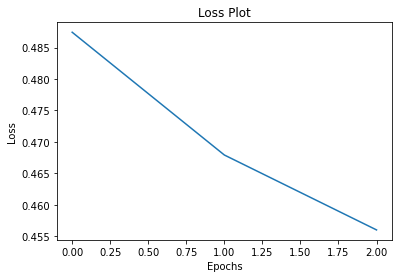

In [65]:
import matplotlib.pyplot as plt
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [106]:
encoder.weights

[<tf.Variable 'cnn__encoder_3/dense_38/kernel:0' shape=(2048, 256) dtype=float32, numpy=
 array([[ 0.07906423, -0.07305035,  0.02868974, ...,  0.01994226,
          0.06199162,  0.03770299],
        [-0.16958316,  0.02862614, -0.01967531, ...,  0.01392494,
         -0.00190343,  0.05438334],
        [-0.08555659, -0.10772238, -0.04963834, ...,  0.11187284,
          0.03932583, -0.01604153],
        ...,
        [-0.07730198,  0.00024443,  0.02351382, ..., -0.03525344,
         -0.073157  , -0.06090371],
        [ 0.05617123,  0.02826956, -0.03355056, ...,  0.04529927,
          0.10224548, -0.17108957],
        [ 0.02586234,  0.01334742, -0.09659585, ..., -0.07062989,
         -0.00835726, -0.05752277]], dtype=float32)>,
 <tf.Variable 'cnn__encoder_3/dense_38/bias:0' shape=(256,) dtype=float32, numpy=
 array([ 0.02842936,  0.04056149, -0.04181682, -0.0103188 , -0.00774593,
        -0.0171052 ,  0.04174636,  0.01815009, -0.01897136,  0.00051018,
        -0.04797055, -0.04309777,  0.015

In [66]:
encoder1 = CNN_Encoder(embedding_dim)
decoder1 = RNN_Decoder(embedding_dim, units, vocab_size)

In [67]:
encoder1.load_weights('encoder')
decoder1.load_weights('decoder')
# encoder1.load_weights(decoder,'./train/ckpt-2')

# Caption

In [4]:
import os
import tensorflow as tf
checkpoint_dir='./latest_checkpoints/'
checkpoint_prefix=os.path.join(checkpoint_dir,'ckpt')


In [7]:
checkpoint=tf.train.Checkpoint(encoder=encoder,
                              decoder=decoder,
                              optimizer=optimizer)

NameError: name 'encoder' is not defined

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 16
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = 7000 + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64
max_length,decoder,load_image,image_features_extract_model,encoder,tokenizer

In [68]:
import matplotlib.pyplot as plt
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder1.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder1(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder1(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [69]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> several ducks walking around a dirt area some have yellow bills <end>
Prediction Caption: several very close up of a strange pair of birds sit down next to each other <end>


/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


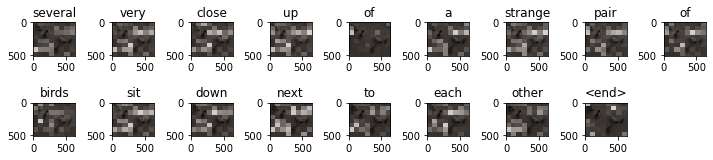

In [73]:
from PIL import Image
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

In [ ]:
Image.open('')

# Evaluate on own image

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [61]:
#decoder,load_image(),image_features_extract_model,encoder,tokenizer,
def evaluate(image):
    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    return result

In [64]:
import os
lt=os.listdir('train2014')
' '.join(evaluate('train2014/'+lt[0]))

'a street sign in jeans stands on a city road <end>'